In [4]:
import numpy as np
import os
from configparser import ConfigParser
from visualization import load_depth
import visualization
from PIL import Image
import pickle
import json
import time
from shutil import copyfile
import moviepy
from moviepy.editor import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from joblib import Parallel, delayed

In [33]:
ini_file = "gta-postprocessing.ini"
visualization.multi_page = False
visualization.ini_file = ini_file
visualization.use_cache = False

conn = visualization.get_connection()
cur = conn.cursor()

CONFIG = ConfigParser()
CONFIG.read(ini_file)
in_directory = r'D:\output-datasets\offroad-4'
out_directory = r'D:\showing-videos\offroad-4'


In [34]:
#run_id = 19
#run_id = 3677
run_id = 4006

cur.execute("""SELECT imagepath, \
      ARRAY[st_x(camera_relative_rotation), st_y(camera_relative_rotation), st_z(camera_relative_rotation)] as camera_relative_rotation,
      ARRAY[st_x(camera_relative_position), st_y(camera_relative_position), st_z(camera_relative_position)] as camera_relative_position 
      FROM snapshots \
      WHERE run_id = {} AND camera_fov != 0 \
      ORDER BY timestamp ASC \
    """.format(run_id))
# camera fov is sanity check for malformed images
results = []
for row in cur:
    res = dict(row)
    #res['camera_relative_rotation'] = np.array(res['camera_relative_rotation'])
    results.append(res)

print('There are {} snapshots'.format(len(results)))

There are 62892 snapshots


In [35]:
# because sometimes I use two cameras heading same direction, pair (position, rotation) is unique identifier
cur.execute("""SELECT DISTINCT \
      ARRAY[st_x(camera_relative_rotation), st_y(camera_relative_rotation), st_z(camera_relative_rotation)] as camera_relative_rotation, 
      ARRAY[st_x(camera_relative_position), st_y(camera_relative_position), st_z(camera_relative_position)] as camera_relative_position 
      FROM snapshots \
      WHERE run_id = {} AND camera_fov != 0 \
      ORDER BY camera_relative_rotation ASC \
    """.format(run_id))
# camera fov is sanity check for malformed images
print('there are following relative camera rotations')
cam_configurations = []
for row in cur:
    print(row['camera_relative_rotation'])
    print(row['camera_relative_position'])
    cam_configurations.append((row['camera_relative_rotation'], row['camera_relative_position']))


there are following relative camera rotations
[-30.0, 0.0, 90.0]
[15.9399995803833, 17.5, 6.07649993896484]
[-30.0, 0.0, 180.0]
[-0.0599999986588955, 33.5, 6.07649993896484]
[-30.0, 0.0, 270.0]
[-16.0599994659424, 17.5, 6.07649993896484]
[0.0, 0.0, 0.0]
[-0.0599999986588955, 1.5, 1.07649993896484]
[0.0, 0.0, 0.0]
[0.480000019073486, 1.5, 1.07649993896484]
[270.0, 0.0, 0.0]
[-0.0599999986588955, 17.5, 25.0764999389648]


In [36]:
def split_results_by_relative_cam_configurations(results):
    res_groups = {}
    for cam_conf in cam_configurations:
        res_groups[str(cam_conf)] = [i for i in results if (i['camera_relative_rotation'], i['camera_relative_position']) == cam_conf]
    return res_groups

def result_group_to_video(results, suffix):
    img_sequence = [os.path.join(in_directory, i['imagepath']+suffix) for i in results]
    clip = ImageSequenceClip(img_sequence, fps=10)
    return clip

def process_depth_image(image):
    image = np.array(image.convert('RGB')) / np.iinfo(np.uint16).max
    return image
    
def result_depth_group_to_video(results, suffix):
    img_sequence = [os.path.join(in_directory, i['imagepath']+suffix) for i in results]
    img_sequence = [Image.open(i) for i in img_sequence]
    workers = 8
    img_sequence = Parallel(n_jobs=workers, backend='threading')(delayed(process_depth_image)(i) for i in img_sequence)
    clip = ImageSequenceClip(img_sequence, fps=10)
    return clip

def process_stencil_image(colors, image):
    image = np.array(image) % 8
    image = colors[image]
    return image
    
def result_stencil_group_to_video(results, suffix):
    colors = (plt.cm.viridis(np.linspace(0, 1, 8))[:, :3] * np.iinfo(np.uint8).max).astype(np.uint8)
    img_sequence = [os.path.join(in_directory, i['imagepath']+suffix) for i in results]
    img_sequence = [Image.open(i) for i in img_sequence]  # IO operation, no need to perallelize
    # from 60 to 16 seconds sppedup, nice, all cores at full load
    workers = 8
    img_sequence = Parallel(n_jobs=workers, backend='threading')(delayed(process_stencil_image)(colors, i) for i in img_sequence)
    clip = ImageSequenceClip(img_sequence, fps=10)

    return clip


### preparing data

In [37]:
result_groups = split_results_by_relative_cam_configurations(results)


In [38]:
for cam_conf, res in result_groups.items():
    print(cam_conf)
    print(len(res))

([-30.0, 0.0, 90.0], [15.9399995803833, 17.5, 6.07649993896484])
10497
([-30.0, 0.0, 180.0], [-0.0599999986588955, 33.5, 6.07649993896484])
10537
([-30.0, 0.0, 270.0], [-16.0599994659424, 17.5, 6.07649993896484])
10543
([0.0, 0.0, 0.0], [-0.0599999986588955, 1.5, 1.07649993896484])
10472
([0.0, 0.0, 0.0], [0.480000019073486, 1.5, 1.07649993896484])
10446
([270.0, 0.0, 0.0], [-0.0599999986588955, 17.5, 25.0764999389648])
10397


### dumping data to videos

In [40]:
for cam_conf, res in result_groups.items():
    clip = result_group_to_video(res, '.jpg')
#    depth_clip = result_depth_group_to_video(res, '-depth.png')
#    stencil_clip = result_stencil_group_to_video(res, '-stencil.png')

    video_name = os.path.join(out_directory, "camera-{}.mp4".format(cam_conf))
    clip.write_videofile(video_name, audio=False, codec='mpeg4', threads=8)
    
#    video_name = os.path.join(out_directory, "camera-{}-depth.mp4".format(cam_conf))
#    depth_clip.write_videofile(video_name, audio=False, codec='mpeg4')
    
#    video_name = os.path.join(out_directory, "camera-{}-stencil.mp4".format(cam_conf))
#    stencil_clip.write_videofile(video_name, audio=False, codec='mpeg4')
    
#time to load images 23.967074155807495
#time to transform images 51.597939252853394
#time to prepare sequence clip 0.0010004043579101562

#time to load images 0.28050708770751953
#time to transform images 63.57286500930786
#time to prepare sequence clip 0.0005006790161132812

[MoviePy] >>>> Building video D:\showing-videos\offroad-4\camera-([-30.0, 0.0, 90.0], [15.9399995803833, 17.5, 6.07649993896484]).mp4
[MoviePy] Writing video D:\showing-videos\offroad-4\camera-([-30.0, 0.0, 90.0], [15.9399995803833, 17.5, 6.07649993896484]).mp4



  1%|█                                                                             | 136/10498 [00:08<11:11, 15.42it/s]


  3%|██                                                                            | 273/10498 [00:18<12:46, 13.33it/s]


  4%|███                                                                           | 409/10498 [00:27<10:39, 15.78it/s]


  5%|████                                                                          | 545/10498 [00:36<11:31, 14.40it/s]


  6%|█████                                                                         | 681/10498 [00:45<10:52, 15.04it/s]


  8%|██████                                                                        | 817/10498 [00:54<09:51, 16.36it/s]


  9%|███████                                                                       | 953/10498 [01:03<10:16, 15.47it/s]


 10%|███████▉                                                                     | 1089/10498 [01:11<10:45, 14.57it/s]


 12%|████████▉                                                                    | 1225/10498 [01:20<10:01, 15.42it/s]


 13%|█████████▉                                                                   | 1361/10498 [01:29<10:44, 14.17it/s]


 14%|██████████▉                                                                  | 1497/10498 [01:39<09:55, 15.12it/s]


 16%|███████████▉                                                                 | 1633/10498 [01:48<10:39, 13.86it/s]


 17%|████████████▉                                                                | 1769/10498 [01:58<10:26, 13.92it/s]


 18%|█████████████▉                                                               | 1905/10498 [02:07<09:23, 15.25it/s]


 19%|██████████████▉                                                              | 2042/10498 [02:16<09:52, 14.28it/s]


 21%|███████████████▉                                                             | 2178/10498 [02:25<09:40, 14.34it/s]


 22%|████████████████▉                                                            | 2314/10498 [02:34<08:54, 15.31it/s]


 23%|█████████████████▉                                                           | 2450/10498 [02:45<09:53, 13.56it/s]


 25%|██████████████████▉                                                          | 2579/10498 [02:56<16:35,  7.96it/s]


 26%|███████████████████▊                                                         | 2697/10498 [03:08<10:27, 12.44it/s]


 27%|████████████████████▊                                                        | 2833/10498 [03:19<09:53, 12.92it/s]


 28%|█████████████████████▊                                                       | 2969/10498 [03:31<10:31, 11.93it/s]


 30%|██████████████████████▊                                                      | 3105/10498 [03:42<09:36, 12.83it/s]


 31%|███████████████████████▊                                                     | 3241/10498 [03:53<10:17, 11.75it/s]


 32%|████████████████████████▊                                                    | 3377/10498 [04:04<08:50, 13.43it/s]


 33%|█████████████████████████▊                                                   | 3513/10498 [04:15<09:52, 11.79it/s]


 35%|██████████████████████████▊                                                  | 3649/10498 [04:26<08:29, 13.45it/s]


 36%|███████████████████████████▊                                                 | 3785/10498 [04:38<08:49, 12.68it/s]


 37%|████████████████████████████▊                                                | 3921/10498 [04:48<09:41, 11.32it/s]


 39%|█████████████████████████████▊                                               | 4057/10498 [04:59<07:38, 14.06it/s]


 40%|██████████████████████████████▊                                              | 4193/10498 [05:10<08:26, 12.46it/s]


 41%|███████████████████████████████▊                                             | 4329/10498 [05:21<07:47, 13.20it/s]


 43%|████████████████████████████████▋                                            | 4465/10498 [05:32<07:55, 12.70it/s]


 44%|█████████████████████████████████▋                                           | 4601/10498 [05:43<07:40, 12.81it/s]


 45%|██████████████████████████████████▋                                          | 4737/10498 [05:54<07:15, 13.24it/s]


 46%|███████████████████████████████████▋                                         | 4873/10498 [06:05<07:26, 12.60it/s]


 48%|████████████████████████████████████▋                                        | 5009/10498 [06:15<06:52, 13.31it/s]


 49%|█████████████████████████████████████▋                                       | 5145/10498 [06:26<07:31, 11.85it/s]


 50%|██████████████████████████████████████▋                                      | 5281/10498 [06:37<06:52, 12.64it/s]


 52%|███████████████████████████████████████▋                                     | 5417/10498 [06:47<06:10, 13.72it/s]


 53%|████████████████████████████████████████▋                                    | 5553/10498 [06:58<06:15, 13.17it/s]


 54%|█████████████████████████████████████████▋                                   | 5689/10498 [07:08<05:46, 13.86it/s]


 55%|██████████████████████████████████████████▋                                  | 5825/10498 [07:19<06:05, 12.78it/s]


 57%|███████████████████████████████████████████▋                                 | 5961/10498 [07:29<05:32, 13.63it/s]


 58%|████████████████████████████████████████████▋                                | 6097/10498 [07:39<05:30, 13.31it/s]


 59%|█████████████████████████████████████████████▋                               | 6233/10498 [07:48<04:44, 15.00it/s]


 61%|██████████████████████████████████████████████▋                              | 6369/10498 [07:58<04:30, 15.25it/s]


 62%|███████████████████████████████████████████████▋                             | 6506/10498 [08:07<04:48, 13.84it/s]


 63%|████████████████████████████████████████████████▋                            | 6644/10498 [08:16<04:10, 15.41it/s]


 65%|█████████████████████████████████████████████████▊                           | 6783/10498 [08:25<04:03, 15.28it/s]


 66%|██████████████████████████████████████████████████▊                          | 6926/10498 [08:35<04:11, 14.19it/s]


 67%|███████████████████████████████████████████████████▊                         | 7066/10498 [08:43<03:44, 15.29it/s]


 69%|████████████████████████████████████████████████████▊                        | 7206/10498 [08:52<03:21, 16.31it/s]


 70%|█████████████████████████████████████████████████████▉                       | 7350/10498 [09:00<02:47, 18.81it/s]


 71%|██████████████████████████████████████████████████████▉                      | 7489/10498 [09:08<02:54, 17.20it/s]


 73%|███████████████████████████████████████████████████████▉                     | 7633/10498 [09:16<02:46, 17.19it/s]


 74%|█████████████████████████████████████████████████████████                    | 7776/10498 [09:25<02:30, 18.03it/s]


 75%|██████████████████████████████████████████████████████████                   | 7915/10498 [09:33<02:28, 17.43it/s]


 77%|███████████████████████████████████████████████████████████                  | 8055/10498 [09:41<02:27, 16.59it/s]


 78%|████████████████████████████████████████████████████████████▏                | 8198/10498 [09:50<02:07, 18.08it/s]


 79%|█████████████████████████████████████████████████████████████▏               | 8337/10498 [09:58<02:01, 17.81it/s]


 81%|██████████████████████████████████████████████████████████████▏              | 8479/10498 [10:06<02:01, 16.68it/s]


 82%|███████████████████████████████████████████████████████████████▏             | 8619/10498 [10:14<01:51, 16.89it/s]


 83%|████████████████████████████████████████████████████████████████▎            | 8760/10498 [10:22<01:46, 16.30it/s]


 85%|█████████████████████████████████████████████████████████████████▎           | 8901/10498 [10:31<01:29, 17.81it/s]


 86%|██████████████████████████████████████████████████████████████████▎          | 9040/10498 [10:39<01:24, 17.30it/s]


 88%|███████████████████████████████████████████████████████████████████▍         | 9188/10498 [10:47<01:19, 16.41it/s]


 89%|████████████████████████████████████████████████████████████████████▍        | 9330/10498 [10:55<01:09, 16.72it/s]


 90%|█████████████████████████████████████████████████████████████████████▌       | 9477/10498 [11:04<00:57, 17.80it/s]


 92%|██████████████████████████████████████████████████████████████████████▌      | 9622/10498 [11:12<00:50, 17.35it/s]


 93%|███████████████████████████████████████████████████████████████████████▌     | 9764/10498 [11:20<00:41, 17.68it/s]


 94%|████████████████████████████████████████████████████████████████████████▋    | 9907/10498 [11:28<00:31, 18.85it/s]


 96%|████████████████████████████████████████████████████████████████████████▉   | 10070/10498 [11:37<00:19, 22.42it/s]


 98%|██████████████████████████████████████████████████████████████████████████▍ | 10274/10498 [11:45<00:09, 23.15it/s]


100%|███████████████████████████████████████████████████████████████████████████▊| 10478/10498 [11:54<00:00, 23.11it/s]


100%|████████████████████████████████████████████████████████████████████████████| 10498/10498 [11:55<00:00, 14.67it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\showing-videos\offroad-4\camera-([-30.0, 0.0, 90.0], [15.9399995803833, 17.5, 6.07649993896484]).mp4 

[MoviePy] >>>> Building video D:\showing-videos\offroad-4\camera-([-30.0, 0.0, 180.0], [-0.0599999986588955, 33.5, 6.07649993896484]).mp4
[MoviePy] Writing video D:\showing-videos\offroad-4\camera-([-30.0, 0.0, 180.0], [-0.0599999986588955, 33.5, 6.07649993896484]).mp4



  1%|▉                                                                             | 134/10538 [00:09<11:26, 15.16it/s]


  3%|██                                                                            | 271/10538 [00:19<13:05, 13.07it/s]


  4%|███                                                                           | 407/10538 [00:28<12:12, 13.84it/s]


  5%|████                                                                          | 543/10538 [00:38<12:03, 13.82it/s]


  6%|█████                                                                         | 679/10538 [00:48<12:15, 13.40it/s]


  8%|██████                                                                        | 815/10538 [00:58<11:43, 13.82it/s]


  9%|███████                                                                       | 951/10538 [01:07<11:09, 14.32it/s]


 10%|███████▉                                                                     | 1087/10538 [01:17<09:51, 15.98it/s]


 12%|████████▉                                                                    | 1223/10538 [01:26<10:14, 15.15it/s]


 13%|█████████▉                                                                   | 1359/10538 [01:35<10:48, 14.15it/s]


 14%|██████████▉                                                                  | 1496/10538 [01:44<09:45, 15.44it/s]


 15%|███████████▉                                                                 | 1632/10538 [01:54<10:05, 14.71it/s]


 17%|████████████▉                                                                | 1768/10538 [02:03<09:58, 14.64it/s]


 18%|█████████████▉                                                               | 1906/10538 [02:11<08:35, 16.75it/s]


 19%|██████████████▉                                                              | 2046/10538 [02:20<08:14, 17.18it/s]


 21%|███████████████▉                                                             | 2183/10538 [02:28<08:49, 15.79it/s]


 22%|████████████████▉                                                            | 2322/10538 [02:36<08:41, 15.76it/s]


 23%|█████████████████▉                                                           | 2458/10538 [02:45<08:37, 15.61it/s]


 25%|██████████████████▉                                                          | 2597/10538 [02:53<08:05, 16.37it/s]


 26%|███████████████████▉                                                         | 2733/10538 [03:01<07:58, 16.31it/s]


 27%|████████████████████▉                                                        | 2869/10538 [03:10<08:06, 15.75it/s]


 29%|█████████████████████▉                                                       | 3005/10538 [03:18<07:21, 17.07it/s]


 30%|██████████████████████▉                                                      | 3142/10538 [03:27<08:12, 15.00it/s]


 31%|███████████████████████▉                                                     | 3278/10538 [03:35<07:36, 15.89it/s]


 32%|████████████████████████▉                                                    | 3414/10538 [03:44<07:34, 15.68it/s]


 34%|█████████████████████████▉                                                   | 3550/10538 [03:52<07:14, 16.09it/s]


 35%|██████████████████████████▉                                                  | 3686/10538 [04:00<06:53, 16.57it/s]


 36%|███████████████████████████▉                                                 | 3822/10538 [04:09<07:01, 15.95it/s]


 38%|████████████████████████████▉                                                | 3958/10538 [04:17<07:16, 15.09it/s]


 39%|█████████████████████████████▉                                               | 4094/10538 [04:26<06:29, 16.54it/s]


 40%|██████████████████████████████▉                                              | 4230/10538 [04:34<06:33, 16.04it/s]


 41%|███████████████████████████████▉                                             | 4366/10538 [04:43<06:29, 15.83it/s]


 43%|████████████████████████████████▉                                            | 4502/10538 [04:51<05:56, 16.94it/s]


 44%|█████████████████████████████████▉                                           | 4638/10538 [05:00<06:16, 15.68it/s]


 45%|██████████████████████████████████▉                                          | 4774/10538 [05:08<05:42, 16.84it/s]


 47%|███████████████████████████████████▉                                         | 4910/10538 [05:16<05:42, 16.44it/s]


 48%|████████████████████████████████████▊                                        | 5046/10538 [05:24<05:27, 16.75it/s]


 49%|█████████████████████████████████████▊                                       | 5182/10538 [05:32<05:36, 15.91it/s]


 50%|██████████████████████████████████████▊                                      | 5318/10538 [05:41<05:07, 16.98it/s]


 52%|███████████████████████████████████████▊                                     | 5454/10538 [05:49<05:37, 15.09it/s]


 53%|████████████████████████████████████████▊                                    | 5590/10538 [05:57<04:52, 16.93it/s]


 54%|█████████████████████████████████████████▊                                   | 5726/10538 [06:05<04:48, 16.69it/s]


 56%|██████████████████████████████████████████▊                                  | 5862/10538 [06:12<04:27, 17.48it/s]


 57%|███████████████████████████████████████████▊                                 | 5998/10538 [06:20<04:04, 18.53it/s]


 58%|████████████████████████████████████████████▊                                | 6137/10538 [06:28<03:55, 18.72it/s]


 60%|█████████████████████████████████████████████▉                               | 6279/10538 [06:35<03:53, 18.23it/s]


 61%|███████████████████████████████████████████████▏                             | 6456/10538 [06:44<03:26, 19.75it/s]


 63%|████████████████████████████████████████████████▌                            | 6645/10538 [06:54<03:18, 19.60it/s]


 65%|██████████████████████████████████████████████████                           | 6847/10538 [07:03<02:49, 21.83it/s]


 67%|███████████████████████████████████████████████████▌                         | 7051/10538 [07:13<02:41, 21.54it/s]


 69%|█████████████████████████████████████████████████████                        | 7255/10538 [07:22<02:36, 20.94it/s]


 71%|██████████████████████████████████████████████████████▌                      | 7459/10538 [07:32<02:26, 21.00it/s]


 73%|███████████████████████████████████████████████████████▉                     | 7663/10538 [07:42<02:16, 21.12it/s]


 75%|█████████████████████████████████████████████████████████▍                   | 7867/10538 [07:51<02:04, 21.52it/s]


 77%|██████████████████████████████████████████████████████████▉                  | 8071/10538 [08:00<01:55, 21.30it/s]


 79%|████████████████████████████████████████████████████████████▍                | 8275/10538 [08:10<01:46, 21.34it/s]


 80%|█████████████████████████████████████████████████████████████▉               | 8479/10538 [08:19<01:36, 21.38it/s]


 82%|███████████████████████████████████████████████████████████████▍             | 8683/10538 [08:29<01:25, 21.66it/s]


 84%|████████████████████████████████████████████████████████████████▉            | 8887/10538 [08:38<01:13, 22.49it/s]


 86%|██████████████████████████████████████████████████████████████████▍          | 9091/10538 [08:48<01:08, 21.12it/s]


 88%|███████████████████████████████████████████████████████████████████▉         | 9294/10538 [08:57<00:56, 21.87it/s]


 90%|█████████████████████████████████████████████████████████████████████▍       | 9497/10538 [09:07<00:50, 20.71it/s]


 92%|██████████████████████████████████████████████████████████████████████▉      | 9701/10538 [09:16<00:37, 22.45it/s]


 94%|████████████████████████████████████████████████████████████████████████▎    | 9904/10538 [09:26<00:29, 21.84it/s]


 96%|████████████████████████████████████████████████████████████████████████▉   | 10106/10538 [09:35<00:20, 20.90it/s]


 98%|██████████████████████████████████████████████████████████████████████████▎ | 10310/10538 [09:44<00:09, 25.17it/s]


100%|███████████████████████████████████████████████████████████████████████████▊| 10514/10538 [09:52<00:00, 25.07it/s]


100%|████████████████████████████████████████████████████████████████████████████| 10538/10538 [09:53<00:00, 23.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\showing-videos\offroad-4\camera-([-30.0, 0.0, 180.0], [-0.0599999986588955, 33.5, 6.07649993896484]).mp4 

[MoviePy] >>>> Building video D:\showing-videos\offroad-4\camera-([-30.0, 0.0, 270.0], [-16.0599994659424, 17.5, 6.07649993896484]).mp4
[MoviePy] Writing video D:\showing-videos\offroad-4\camera-([-30.0, 0.0, 270.0], [-16.0599994659424, 17.5, 6.07649993896484]).mp4



  1%|▉                                                                             | 135/10544 [00:07<09:40, 17.92it/s]


  3%|██                                                                            | 272/10544 [00:15<09:24, 18.18it/s]


  4%|███                                                                           | 408/10544 [00:23<09:27, 17.87it/s]


  5%|████                                                                          | 544/10544 [00:30<09:16, 17.96it/s]


  6%|█████                                                                         | 680/10544 [00:38<09:30, 17.29it/s]


  8%|██████                                                                        | 816/10544 [00:46<09:19, 17.38it/s]


  9%|███████                                                                       | 953/10544 [00:54<09:37, 16.62it/s]


 10%|███████▉                                                                     | 1090/10544 [01:02<08:49, 17.86it/s]


 12%|████████▉                                                                    | 1226/10544 [01:10<09:31, 16.30it/s]


 13%|█████████▉                                                                   | 1362/10544 [01:18<09:01, 16.95it/s]


 14%|██████████▉                                                                  | 1500/10544 [01:26<07:48, 19.29it/s]


 16%|███████████▉                                                                 | 1641/10544 [01:33<08:02, 18.44it/s]


 17%|█████████████                                                                | 1781/10544 [01:41<08:42, 16.76it/s]


 18%|██████████████                                                               | 1919/10544 [01:49<07:57, 18.08it/s]


 20%|███████████████                                                              | 2060/10544 [01:57<07:33, 18.72it/s]


 21%|████████████████                                                             | 2197/10544 [02:04<08:02, 17.31it/s]


 22%|█████████████████                                                            | 2337/10544 [02:12<07:58, 17.16it/s]


 23%|██████████████████                                                           | 2473/10544 [02:20<07:46, 17.29it/s]


 25%|███████████████████                                                          | 2611/10544 [02:27<07:25, 17.79it/s]


 26%|████████████████████                                                         | 2748/10544 [02:35<07:20, 17.69it/s]


 27%|█████████████████████                                                        | 2885/10544 [02:43<07:02, 18.12it/s]


 29%|██████████████████████                                                       | 3022/10544 [02:51<06:44, 18.59it/s]


 30%|███████████████████████                                                      | 3160/10544 [02:58<06:53, 17.85it/s]


 31%|████████████████████████                                                     | 3299/10544 [03:06<06:31, 18.51it/s]


 33%|█████████████████████████                                                    | 3438/10544 [03:14<06:28, 18.30it/s]


 34%|██████████████████████████                                                   | 3576/10544 [03:22<06:23, 18.15it/s]


 35%|███████████████████████████                                                  | 3712/10544 [03:29<06:25, 17.70it/s]


 36%|████████████████████████████                                                 | 3848/10544 [03:37<06:24, 17.43it/s]


 38%|█████████████████████████████                                                | 3986/10544 [03:44<05:43, 19.08it/s]


 39%|██████████████████████████████                                               | 4123/10544 [03:52<05:44, 18.66it/s]


 40%|███████████████████████████████                                              | 4262/10544 [04:00<05:34, 18.75it/s]


 42%|████████████████████████████████                                             | 4399/10544 [04:07<05:37, 18.19it/s]


 43%|█████████████████████████████████▏                                           | 4536/10544 [04:15<05:32, 18.09it/s]


 44%|██████████████████████████████████▏                                          | 4675/10544 [04:22<05:22, 18.20it/s]


 46%|███████████████████████████████████▏                                         | 4814/10544 [04:30<05:38, 16.94it/s]


 47%|████████████████████████████████████▏                                        | 4954/10544 [04:38<04:51, 19.14it/s]


 48%|█████████████████████████████████████▏                                       | 5094/10544 [04:45<04:55, 18.44it/s]


 50%|██████████████████████████████████████▏                                      | 5235/10544 [04:53<04:35, 19.29it/s]


 51%|███████████████████████████████████████▎                                     | 5378/10544 [05:01<04:35, 18.78it/s]


 52%|████████████████████████████████████████▎                                    | 5522/10544 [05:08<04:29, 18.63it/s]


 54%|█████████████████████████████████████████▎                                   | 5665/10544 [05:16<04:30, 18.03it/s]


 55%|██████████████████████████████████████████▍                                  | 5807/10544 [05:24<04:18, 18.31it/s]


 56%|███████████████████████████████████████████▍                                 | 5955/10544 [05:32<04:10, 18.33it/s]


 58%|████████████████████████████████████████████▌                                | 6106/10544 [05:40<03:56, 18.80it/s]


 59%|█████████████████████████████████████████████▊                               | 6267/10544 [05:48<03:39, 19.47it/s]


 61%|███████████████████████████████████████████████                              | 6453/10544 [05:57<03:15, 20.87it/s]


 63%|████████████████████████████████████████████████▌                            | 6656/10544 [06:07<03:04, 21.05it/s]


 65%|██████████████████████████████████████████████████                           | 6858/10544 [06:17<02:51, 21.55it/s]


 67%|███████████████████████████████████████████████████▌                         | 7062/10544 [06:26<02:36, 22.26it/s]


 69%|█████████████████████████████████████████████████████                        | 7265/10544 [06:36<02:31, 21.70it/s]


 71%|██████████████████████████████████████████████████████▌                      | 7469/10544 [06:45<02:21, 21.76it/s]


 73%|████████████████████████████████████████████████████████                     | 7672/10544 [06:55<02:12, 21.65it/s]


 75%|█████████████████████████████████████████████████████████▌                   | 7876/10544 [07:04<02:01, 22.00it/s]


 77%|██████████████████████████████████████████████████████████▉                  | 8078/10544 [07:13<01:51, 22.18it/s]


 79%|████████████████████████████████████████████████████████████▍                | 8282/10544 [07:23<01:42, 22.04it/s]


 80%|█████████████████████████████████████████████████████████████▉               | 8484/10544 [07:32<01:38, 20.88it/s]


 82%|███████████████████████████████████████████████████████████████▍             | 8688/10544 [07:42<01:29, 20.84it/s]


 84%|████████████████████████████████████████████████████████████████▉            | 8892/10544 [07:51<01:19, 20.90it/s]


 86%|██████████████████████████████████████████████████████████████████▍          | 9096/10544 [08:01<01:05, 22.23it/s]


 88%|███████████████████████████████████████████████████████████████████▉         | 9300/10544 [08:10<00:57, 21.64it/s]


 90%|█████████████████████████████████████████████████████████████████████▍       | 9504/10544 [08:19<00:47, 21.93it/s]


 92%|██████████████████████████████████████████████████████████████████████▉      | 9708/10544 [08:29<00:39, 21.10it/s]


 94%|████████████████████████████████████████████████████████████████████████▍    | 9912/10544 [08:38<00:28, 22.14it/s]


 96%|████████████████████████████████████████████████████████████████████████▉   | 10116/10544 [08:48<00:20, 20.87it/s]


 98%|██████████████████████████████████████████████████████████████████████████▎ | 10307/10544 [08:57<00:10, 23.35it/s]


100%|███████████████████████████████████████████████████████████████████████████▊| 10511/10544 [09:05<00:01, 24.74it/s]


100%|████████████████████████████████████████████████████████████████████████████| 10544/10544 [09:07<00:00, 25.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\showing-videos\offroad-4\camera-([-30.0, 0.0, 270.0], [-16.0599994659424, 17.5, 6.07649993896484]).mp4 

[MoviePy] >>>> Building video D:\showing-videos\offroad-4\camera-([0.0, 0.0, 0.0], [-0.0599999986588955, 1.5, 1.07649993896484]).mp4
[MoviePy] Writing video D:\showing-videos\offroad-4\camera-([0.0, 0.0, 0.0], [-0.0599999986588955, 1.5, 1.07649993896484]).mp4



  1%|█                                                                             | 138/10473 [00:07<09:41, 17.77it/s]


  3%|██                                                                            | 276/10473 [00:15<09:23, 18.10it/s]


  4%|███                                                                           | 412/10473 [00:22<10:29, 15.99it/s]


  5%|████▏                                                                         | 568/10473 [00:31<08:25, 19.61it/s]


  7%|█████▍                                                                        | 728/10473 [00:39<08:09, 19.91it/s]


  8%|██████▌                                                                       | 885/10473 [00:48<08:15, 19.34it/s]


 10%|███████▌                                                                     | 1033/10473 [00:55<08:24, 18.70it/s]


 11%|████████▋                                                                    | 1184/10473 [01:03<07:58, 19.43it/s]


 13%|█████████▊                                                                   | 1332/10473 [01:11<07:51, 19.40it/s]


 14%|██████████▊                                                                  | 1470/10473 [01:19<07:53, 19.01it/s]


 16%|███████████▉                                                                 | 1632/10473 [01:27<07:57, 18.52it/s]


 17%|█████████████▏                                                               | 1786/10473 [01:35<07:29, 19.35it/s]


 19%|██████████████▎                                                              | 1949/10473 [01:44<07:23, 19.23it/s]


 20%|███████████████▍                                                             | 2097/10473 [01:51<07:02, 19.81it/s]


 22%|████████████████▋                                                            | 2270/10473 [02:00<07:23, 18.49it/s]


 23%|██████████████████                                                           | 2450/10473 [02:09<06:35, 20.29it/s]


 25%|███████████████████▎                                                         | 2619/10473 [02:18<06:12, 21.06it/s]


 27%|████████████████████▌                                                        | 2796/10473 [02:27<06:20, 20.19it/s]


 28%|█████████████████████▊                                                       | 2961/10473 [02:35<06:28, 19.33it/s]


 30%|███████████████████████                                                      | 3141/10473 [02:45<06:16, 19.47it/s]


 32%|████████████████████████▍                                                    | 3322/10473 [02:54<05:48, 20.53it/s]


 34%|█████████████████████████▊                                                   | 3509/10473 [03:03<05:34, 20.81it/s]


 35%|███████████████████████████▏                                                 | 3702/10473 [03:13<05:41, 19.81it/s]


 37%|████████████████████████████▋                                                | 3896/10473 [03:22<06:09, 17.78it/s]


 39%|██████████████████████████████                                               | 4093/10473 [03:32<05:10, 20.54it/s]


 41%|███████████████████████████████▌                                             | 4292/10473 [03:42<05:01, 20.50it/s]


 43%|█████████████████████████████████                                            | 4489/10473 [03:52<04:51, 20.52it/s]


 45%|██████████████████████████████████▍                                          | 4691/10473 [04:01<04:42, 20.50it/s]


 47%|███████████████████████████████████▉                                         | 4891/10473 [04:11<04:37, 20.11it/s]


 49%|█████████████████████████████████████▍                                       | 5093/10473 [04:21<04:50, 18.54it/s]


 50%|██████████████████████████████████████▊                                      | 5286/10473 [04:30<04:11, 20.64it/s]


 52%|████████████████████████████████████████▎                                    | 5486/10473 [04:40<03:59, 20.81it/s]


 54%|█████████████████████████████████████████▊                                   | 5690/10473 [04:50<03:40, 21.65it/s]


 56%|███████████████████████████████████████████▎                                 | 5892/10473 [05:00<03:34, 21.37it/s]


 58%|████████████████████████████████████████████▊                                | 6096/10473 [05:09<03:30, 20.76it/s]


 60%|██████████████████████████████████████████████▎                              | 6300/10473 [05:19<03:13, 21.55it/s]


 62%|███████████████████████████████████████████████▊                             | 6504/10473 [05:28<02:54, 22.72it/s]


 64%|█████████████████████████████████████████████████▎                           | 6708/10473 [05:37<02:48, 22.29it/s]


 66%|██████████████████████████████████████████████████▊                          | 6912/10473 [05:46<02:30, 23.61it/s]


 68%|████████████████████████████████████████████████████▎                        | 7116/10473 [05:55<02:27, 22.70it/s]


 70%|█████████████████████████████████████████████████████▊                       | 7320/10473 [06:04<02:16, 23.16it/s]


 72%|███████████████████████████████████████████████████████▎                     | 7524/10473 [06:13<02:04, 23.59it/s]


 74%|████████████████████████████████████████████████████████▊                    | 7728/10473 [06:21<01:55, 23.67it/s]


 76%|██████████████████████████████████████████████████████████▎                  | 7932/10473 [06:30<01:48, 23.33it/s]


 78%|███████████████████████████████████████████████████████████▊                 | 8136/10473 [06:38<01:36, 24.13it/s]


 80%|█████████████████████████████████████████████████████████████▎               | 8340/10473 [06:47<01:29, 23.75it/s]


 82%|██████████████████████████████████████████████████████████████▊              | 8544/10473 [06:56<01:21, 23.59it/s]


 84%|████████████████████████████████████████████████████████████████▎            | 8748/10473 [07:04<01:13, 23.56it/s]


 85%|█████████████████████████████████████████████████████████████████▊           | 8952/10473 [07:13<01:05, 23.30it/s]


 87%|███████████████████████████████████████████████████████████████████▎         | 9156/10473 [07:22<00:55, 23.82it/s]


 89%|████████████████████████████████████████████████████████████████████▊        | 9360/10473 [07:30<00:45, 24.40it/s]


 91%|██████████████████████████████████████████████████████████████████████▎      | 9564/10473 [07:39<00:41, 21.96it/s]


 93%|███████████████████████████████████████████████████████████████████████▊     | 9768/10473 [07:48<00:29, 24.28it/s]


 95%|█████████████████████████████████████████████████████████████████████████▎   | 9972/10473 [07:56<00:20, 23.87it/s]


 97%|█████████████████████████████████████████████████████████████████████████▊  | 10176/10473 [08:05<00:12, 23.33it/s]


 99%|███████████████████████████████████████████████████████████████████████████▎| 10380/10473 [08:13<00:03, 28.71it/s]


100%|████████████████████████████████████████████████████████████████████████████| 10473/10473 [08:17<00:00, 28.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\showing-videos\offroad-4\camera-([0.0, 0.0, 0.0], [-0.0599999986588955, 1.5, 1.07649993896484]).mp4 

[MoviePy] >>>> Building video D:\showing-videos\offroad-4\camera-([0.0, 0.0, 0.0], [0.480000019073486, 1.5, 1.07649993896484]).mp4
[MoviePy] Writing video D:\showing-videos\offroad-4\camera-([0.0, 0.0, 0.0], [0.480000019073486, 1.5, 1.07649993896484]).mp4



  2%|█▏                                                                            | 162/10447 [00:08<09:04, 18.88it/s]


  3%|██▎                                                                           | 318/10447 [00:16<09:24, 17.94it/s]


  4%|███▌                                                                          | 470/10447 [00:24<08:45, 19.00it/s]


  6%|████▋                                                                         | 623/10447 [00:32<08:18, 19.71it/s]


  8%|█████▊                                                                        | 784/10447 [00:41<08:15, 19.52it/s]


  9%|██████▉                                                                       | 936/10447 [00:48<08:08, 19.49it/s]


 10%|████████                                                                     | 1090/10447 [00:57<08:03, 19.36it/s]


 12%|█████████                                                                    | 1236/10447 [01:04<08:39, 17.73it/s]


 13%|██████████▏                                                                  | 1377/10447 [01:12<08:14, 18.33it/s]


 15%|███████████▏                                                                 | 1526/10447 [01:20<08:10, 18.17it/s]


 16%|████████████▍                                                                | 1694/10447 [01:28<07:47, 18.72it/s]


 18%|█████████████▋                                                               | 1851/10447 [01:37<07:38, 18.74it/s]


 19%|██████████████▊                                                              | 2007/10447 [01:45<07:14, 19.41it/s]


 21%|████████████████▏                                                            | 2191/10447 [01:54<07:34, 18.16it/s]


 23%|█████████████████▎                                                           | 2351/10447 [02:02<06:40, 20.21it/s]


 24%|██████████████████▋                                                          | 2533/10447 [02:12<07:06, 18.53it/s]


 26%|███████████████████▊                                                         | 2695/10447 [02:20<06:45, 19.13it/s]


 28%|█████████████████████▏                                                       | 2878/10447 [02:29<06:13, 20.25it/s]


 29%|██████████████████████▌                                                      | 3066/10447 [02:39<06:11, 19.87it/s]


 31%|███████████████████████▉                                                     | 3241/10447 [02:48<05:59, 20.06it/s]


 33%|█████████████████████████▎                                                   | 3432/10447 [02:57<05:42, 20.49it/s]


 35%|██████████████████████████▋                                                  | 3623/10447 [03:07<06:11, 18.38it/s]


 36%|████████████████████████████                                                 | 3802/10447 [03:16<05:26, 20.37it/s]


 38%|█████████████████████████████▍                                               | 3997/10447 [03:25<05:19, 20.17it/s]


 40%|██████████████████████████████▉                                              | 4194/10447 [03:35<05:13, 19.95it/s]


 42%|████████████████████████████████▍                                            | 4396/10447 [03:45<04:45, 21.22it/s]


 44%|█████████████████████████████████▊                                           | 4596/10447 [03:55<04:40, 20.86it/s]


 46%|███████████████████████████████████▎                                         | 4792/10447 [04:05<04:31, 20.84it/s]


 48%|████████████████████████████████████▊                                        | 4990/10447 [04:14<04:32, 20.04it/s]


 50%|██████████████████████████████████████▏                                      | 5186/10447 [04:24<04:23, 19.99it/s]


 52%|███████████████████████████████████████▋                                     | 5387/10447 [04:34<04:10, 20.23it/s]


 54%|█████████████████████████████████████████▏                                   | 5591/10447 [04:43<03:48, 21.24it/s]


 55%|██████████████████████████████████████████▋                                  | 5795/10447 [04:53<03:42, 20.91it/s]


 57%|████████████████████████████████████████████▏                                | 5999/10447 [05:02<03:22, 21.99it/s]


 59%|█████████████████████████████████████████████▋                               | 6203/10447 [05:12<03:19, 21.26it/s]


 61%|███████████████████████████████████████████████▏                             | 6406/10447 [05:21<03:11, 21.12it/s]


 63%|████████████████████████████████████████████████▋                            | 6610/10447 [05:30<03:04, 20.79it/s]


 65%|██████████████████████████████████████████████████▏                          | 6814/10447 [05:39<02:41, 22.55it/s]


 67%|███████████████████████████████████████████████████▋                         | 7018/10447 [05:48<02:25, 23.59it/s]


 69%|█████████████████████████████████████████████████████▏                       | 7222/10447 [05:57<02:20, 23.00it/s]


 71%|██████████████████████████████████████████████████████▋                      | 7426/10447 [06:06<02:14, 22.50it/s]


 73%|████████████████████████████████████████████████████████▏                    | 7630/10447 [06:15<02:01, 23.12it/s]


 75%|█████████████████████████████████████████████████████████▋                   | 7834/10447 [06:24<01:52, 23.17it/s]


 77%|███████████████████████████████████████████████████████████▏                 | 8038/10447 [06:32<01:42, 23.53it/s]


 79%|████████████████████████████████████████████████████████████▋                | 8242/10447 [06:41<01:36, 22.93it/s]


 81%|██████████████████████████████████████████████████████████████▎              | 8446/10447 [06:50<01:27, 22.95it/s]


 83%|███████████████████████████████████████████████████████████████▊             | 8650/10447 [06:58<01:18, 22.97it/s]


 85%|█████████████████████████████████████████████████████████████████▎           | 8854/10447 [07:07<01:10, 22.54it/s]


 87%|██████████████████████████████████████████████████████████████████▊          | 9058/10447 [07:16<00:59, 23.47it/s]


 89%|████████████████████████████████████████████████████████████████████▎        | 9262/10447 [07:24<00:51, 22.92it/s]


 91%|█████████████████████████████████████████████████████████████████████▊       | 9466/10447 [07:33<00:41, 23.81it/s]


 93%|███████████████████████████████████████████████████████████████████████▎     | 9670/10447 [07:42<00:35, 22.17it/s]


 95%|████████████████████████████████████████████████████████████████████████▊    | 9874/10447 [07:50<00:23, 24.39it/s]


 96%|█████████████████████████████████████████████████████████████████████████▎  | 10078/10447 [07:59<00:15, 23.27it/s]


 98%|██████████████████████████████████████████████████████████████████████████▊ | 10282/10447 [08:08<00:07, 21.67it/s]


100%|████████████████████████████████████████████████████████████████████████████| 10447/10447 [08:15<00:00, 27.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\showing-videos\offroad-4\camera-([0.0, 0.0, 0.0], [0.480000019073486, 1.5, 1.07649993896484]).mp4 

[MoviePy] >>>> Building video D:\showing-videos\offroad-4\camera-([270.0, 0.0, 0.0], [-0.0599999986588955, 17.5, 25.0764999389648]).mp4
[MoviePy] Writing video D:\showing-videos\offroad-4\camera-([270.0, 0.0, 0.0], [-0.0599999986588955, 17.5, 25.0764999389648]).mp4



  1%|█                                                                             | 135/10398 [00:07<09:11, 18.61it/s]


  3%|██                                                                            | 275/10398 [00:15<09:08, 18.46it/s]


  4%|███                                                                           | 412/10398 [00:22<09:28, 17.58it/s]


  5%|████                                                                          | 549/10398 [00:30<09:06, 18.02it/s]


  7%|█████▏                                                                        | 687/10398 [00:37<09:01, 17.94it/s]


  8%|██████▏                                                                       | 827/10398 [00:45<08:27, 18.87it/s]


  9%|███████▎                                                                      | 967/10398 [00:53<08:36, 18.24it/s]


 11%|████████▏                                                                    | 1104/10398 [01:00<09:03, 17.10it/s]


 12%|█████████▏                                                                   | 1241/10398 [01:08<08:47, 17.36it/s]


 13%|██████████▏                                                                  | 1377/10398 [01:16<09:08, 16.45it/s]


 15%|███████████▏                                                                 | 1513/10398 [01:24<08:40, 17.08it/s]


 16%|████████████▏                                                                | 1649/10398 [01:32<08:55, 16.33it/s]


 17%|█████████████▏                                                               | 1785/10398 [01:40<08:16, 17.35it/s]


 18%|██████████████▏                                                              | 1921/10398 [01:48<08:40, 16.28it/s]


 20%|███████████████▏                                                             | 2057/10398 [01:56<08:15, 16.82it/s]


 21%|████████████████▏                                                            | 2193/10398 [02:05<08:27, 16.17it/s]


 22%|█████████████████▏                                                           | 2329/10398 [02:13<08:08, 16.52it/s]


 24%|██████████████████▎                                                          | 2465/10398 [02:21<07:55, 16.67it/s]


 25%|███████████████████▎                                                         | 2601/10398 [02:29<07:34, 17.15it/s]


 26%|████████████████████▎                                                        | 2737/10398 [02:37<08:08, 15.68it/s]


 28%|█████████████████████▎                                                       | 2873/10398 [02:45<07:16, 17.22it/s]


 29%|██████████████████████▎                                                      | 3009/10398 [02:53<07:10, 17.18it/s]


 30%|███████████████████████▎                                                     | 3146/10398 [03:01<06:57, 17.38it/s]


 32%|████████████████████████▎                                                    | 3282/10398 [03:09<07:21, 16.13it/s]


 33%|█████████████████████████▎                                                   | 3418/10398 [03:18<06:39, 17.45it/s]


 34%|██████████████████████████▎                                                  | 3554/10398 [03:26<06:45, 16.89it/s]


 35%|███████████████████████████▎                                                 | 3690/10398 [03:34<06:18, 17.74it/s]


 37%|████████████████████████████▎                                                | 3826/10398 [03:42<06:30, 16.84it/s]


 38%|█████████████████████████████▎                                               | 3962/10398 [03:50<06:35, 16.28it/s]


 39%|██████████████████████████████▎                                              | 4098/10398 [03:58<06:24, 16.37it/s]


 41%|███████████████████████████████▎                                             | 4234/10398 [04:06<06:07, 16.75it/s]


 42%|████████████████████████████████▎                                            | 4370/10398 [04:14<05:54, 16.99it/s]


 43%|█████████████████████████████████▍                                           | 4507/10398 [04:22<05:27, 17.97it/s]


 45%|██████████████████████████████████▍                                          | 4644/10398 [04:29<05:17, 18.14it/s]


 46%|███████████████████████████████████▍                                         | 4780/10398 [04:37<05:10, 18.07it/s]


 47%|████████████████████████████████████▍                                        | 4918/10398 [04:44<05:02, 18.12it/s]


 49%|█████████████████████████████████████▍                                       | 5056/10398 [04:52<04:46, 18.63it/s]


 50%|██████████████████████████████████████▍                                      | 5195/10398 [05:00<04:46, 18.13it/s]


 51%|███████████████████████████████████████▍                                     | 5331/10398 [05:07<04:37, 18.29it/s]


 53%|████████████████████████████████████████▍                                    | 5468/10398 [05:15<04:20, 18.90it/s]


 54%|█████████████████████████████████████████▍                                   | 5604/10398 [05:22<04:11, 19.03it/s]


 55%|██████████████████████████████████████████▌                                  | 5742/10398 [05:30<04:10, 18.59it/s]


 57%|███████████████████████████████████████████▋                                 | 5895/10398 [05:38<04:01, 18.68it/s]


 58%|████████████████████████████████████████████▊                                | 6043/10398 [05:45<03:53, 18.69it/s]


 60%|█████████████████████████████████████████████▉                               | 6205/10398 [05:54<03:29, 20.00it/s]


 62%|███████████████████████████████████████████████▍                             | 6404/10398 [06:03<03:06, 21.36it/s]


 64%|████████████████████████████████████████████████▉                            | 6608/10398 [06:13<02:55, 21.57it/s]


 66%|██████████████████████████████████████████████████▍                          | 6812/10398 [06:22<02:36, 22.94it/s]


 67%|███████████████████████████████████████████████████▉                         | 7016/10398 [06:31<02:25, 23.25it/s]


 69%|█████████████████████████████████████████████████████▍                       | 7220/10398 [06:40<02:16, 23.21it/s]


 71%|██████████████████████████████████████████████████████▉                      | 7424/10398 [06:49<02:08, 23.06it/s]


 73%|████████████████████████████████████████████████████████▍                    | 7628/10398 [06:58<02:10, 21.23it/s]


 75%|█████████████████████████████████████████████████████████▉                   | 7832/10398 [07:07<01:45, 24.36it/s]


 77%|███████████████████████████████████████████████████████████▌                 | 8036/10398 [07:16<01:50, 21.29it/s]


 79%|█████████████████████████████████████████████████████████████                | 8240/10398 [07:25<01:38, 21.96it/s]


 81%|██████████████████████████████████████████████████████████████▌              | 8444/10398 [07:34<01:30, 21.70it/s]


 83%|████████████████████████████████████████████████████████████████             | 8648/10398 [07:44<01:25, 20.48it/s]


 85%|█████████████████████████████████████████████████████████████████▌           | 8852/10398 [07:53<01:10, 22.03it/s]


 87%|███████████████████████████████████████████████████████████████████          | 9056/10398 [08:03<01:02, 21.56it/s]


 89%|████████████████████████████████████████████████████████████████████▌        | 9260/10398 [08:12<00:52, 21.84it/s]


 91%|██████████████████████████████████████████████████████████████████████       | 9464/10398 [08:22<00:45, 20.67it/s]


 93%|███████████████████████████████████████████████████████████████████████▌     | 9668/10398 [08:31<00:33, 21.51it/s]


 95%|█████████████████████████████████████████████████████████████████████████    | 9872/10398 [08:40<00:23, 21.96it/s]


 97%|█████████████████████████████████████████████████████████████████████████▌  | 10064/10398 [08:50<00:16, 20.52it/s]


 98%|██████████████████████████████████████████████████████████████████████████▋ | 10226/10398 [08:58<00:09, 18.95it/s]


100%|████████████████████████████████████████████████████████████████████████████| 10398/10398 [09:07<00:00, 19.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\showing-videos\offroad-4\camera-([270.0, 0.0, 0.0], [-0.0599999986588955, 17.5, 25.0764999389648]).mp4 



In [ ]:
name = os.path.join(in_directory, result_groups['[0, 0, 0]'][0]['imagepath']+'-depth.png')
depth_arr = np.array(Image.open(name).convert('RGB'))
depth_arr_2 = np.array(Image.open(name).convert('L').convert('RGB'))
depth_arr_3 = np.array(Image.open(name).convert('L'))
arr_single = np.array(Image.open(name))

In [ ]:
depth_arr.max()

In [ ]:
arr_single.max()

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.imshow(arr_single, cmap='gray')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(depth_arr_3, cmap='gray')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(depth_arr_2)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(depth_arr)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.hist(arr_single.flatten())
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.hist(depth_arr.flatten())
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.hist(depth_arr_2.flatten())
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.hist(depth_arr_3.flatten())
plt.show()

In [37]:
arr_single_cropped = arr_single[arr_single < 256]
fig = plt.figure(figsize=(10, 10))
plt.hist(arr_single_cropped.flatten())
plt.show()

NameError: name 'arr_single' is not defined

In [116]:
im_stencil = os.path.join(in_directory, next(iter(result_groups.values()))[0]['imagepath']+'-stencil.png')
im_stencil = np.array(Image.open(im_stencil))
im_stencil = im_stencil % 8
colors = (plt.cm.viridis(np.linspace(0, 1, 8))[:, :3] * np.iinfo(np.uint8).max).astype(np.uint8)
im_stencil = colors[im_stencil]

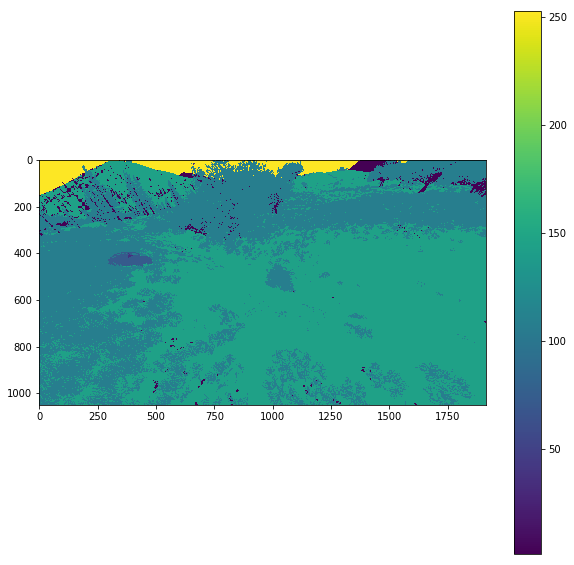

In [117]:
fig = plt.figure(figsize=(10, 10))
ii = plt.imshow(im_stencil)
plt.colorbar(ii)
plt.show()

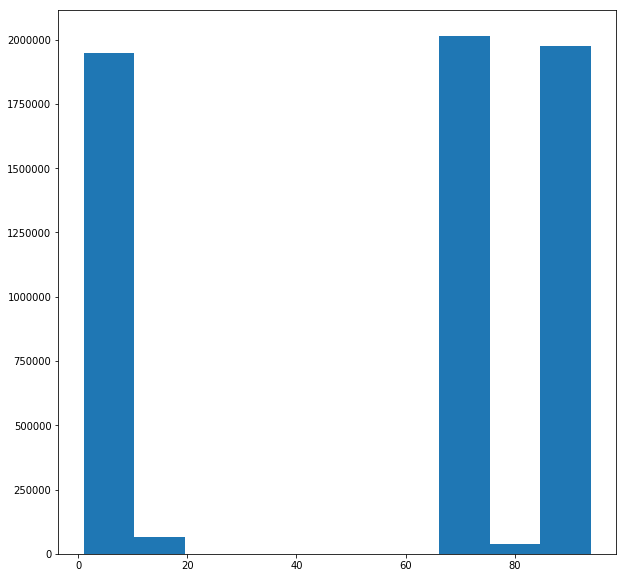

In [56]:
fig = plt.figure(figsize=(10, 10))
plt.hist(im_stencil.flatten())
plt.show()